Fetching data for ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'TSLA']...


[*********************100%***********************]  5 of 5 completed


Data fetched successfully. Shape: (500, 5)

BASIC STATISTICS

Annualized Returns:
AAPL: 0.0805
MSFT: 0.2257
AMZN: 0.3148
GOOGL: 0.2382
TSLA: 0.2351

Annualized Volatilities:
AAPL: 4.3759
MSFT: 3.6378
AMZN: 4.9726
GOOGL: 4.7277
TSLA: 10.1452
Calculating efficient frontier without short selling...
Calculating efficient frontier with short selling...


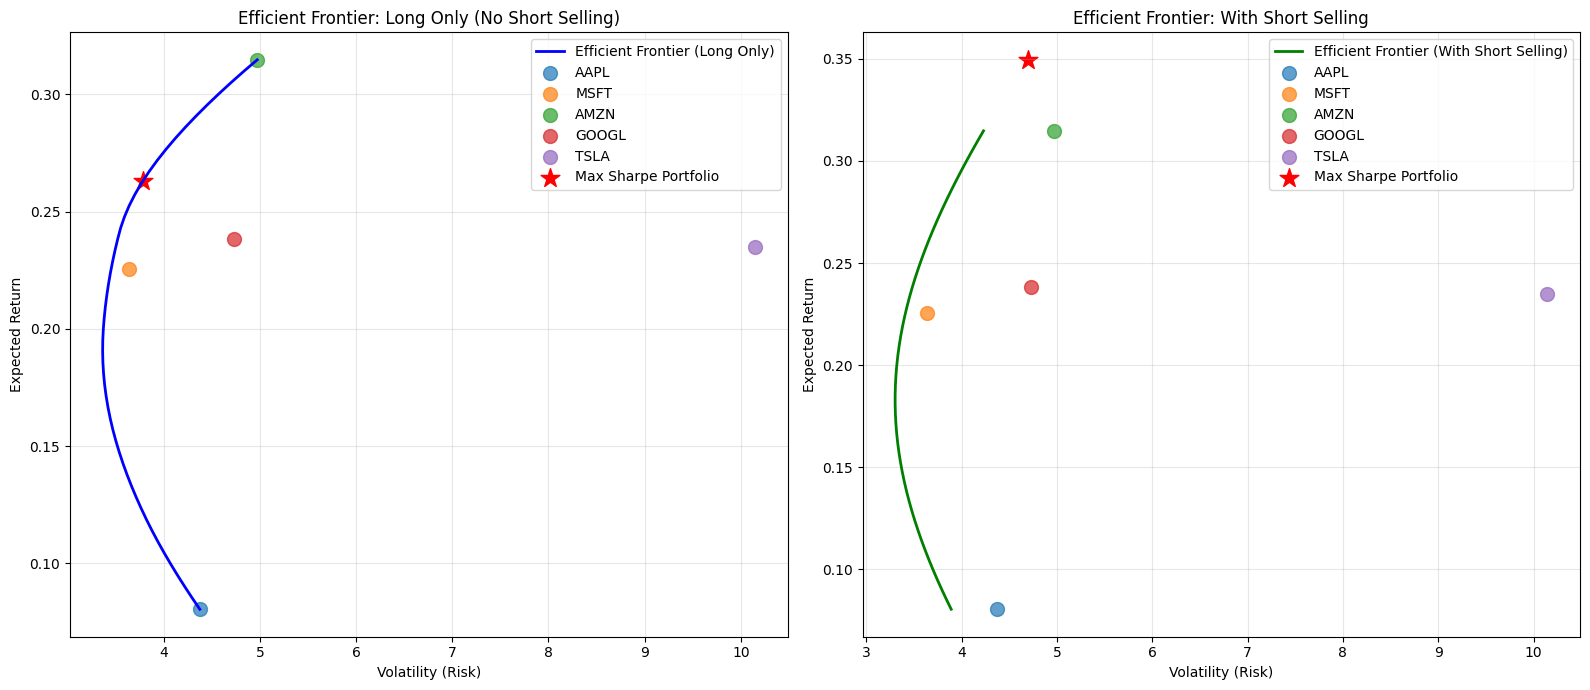


PORTFOLIO ANALYSIS RESULTS

MAXIMUM SHARPE RATIO PORTFOLIO (Long Only):
Expected Return: 0.2632
Volatility: 3.7860
Sharpe Ratio: 0.0642
Weights:
  AAPL: 0.0000
  MSFT: 0.4024
  AMZN: 0.1346
  GOOGL: 0.4631
  TSLA: 0.0000

MAXIMUM SHARPE RATIO PORTFOLIO (With Short Selling):
Expected Return: 0.3496
Volatility: 4.6980
Sharpe Ratio: 0.0701
Weights:
  AAPL: -0.4963 (SHORT)
  MSFT: 0.5517 (LONG)
  AMZN: 0.2349 (LONG)
  GOOGL: 0.7438 (LONG)
  TSLA: -0.0342 (SHORT)



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

class EfficientFrontier:
    def __init__(self, returns):
        """
        Initialize with returns data
        """
        self.returns = returns
        self.mean_returns = returns.mean()
        self.cov_matrix = returns.cov()
        self.n_assets = len(returns.columns)
        
    def portfolio_stats(self, weights):
        """
        Calculate portfolio return and volatility
        """
        portfolio_return = np.sum(weights * self.mean_returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(self.cov_matrix, weights)))
        return portfolio_return, portfolio_volatility
    
    def negative_sharpe_ratio(self, weights, risk_free_rate=0.02):
        """
        Calculate negative Sharpe ratio (for minimization)
        """
        p_return, p_volatility = self.portfolio_stats(weights)
        return -(p_return - risk_free_rate) / p_volatility
    
    def portfolio_volatility(self, weights):
        """
        Calculate portfolio volatility
        """
        return np.sqrt(np.dot(weights.T, np.dot(self.cov_matrix, weights)))
    
    def efficient_frontier(self, target_returns, allow_short_selling=True):
        """
        Generate efficient frontier points
        """
        efficient_portfolios = []
        
        for target_return in target_returns:
            # Constraints
            constraints = [
                {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # weights sum to 1
                {'type': 'eq', 'fun': lambda x: np.sum(x * self.mean_returns) - target_return}  # target return
            ]
            
            # Bounds
            if allow_short_selling:
                bounds = tuple((-1, 1) for _ in range(self.n_assets))  # Allow short selling
            else:
                bounds = tuple((0, 1) for _ in range(self.n_assets))   # Long only
            
            # Initial guess
            x0 = np.array([1/self.n_assets] * self.n_assets)
            
            # Optimize
            result = minimize(
                self.portfolio_volatility,
                x0,
                method='SLSQP',
                bounds=bounds,
                constraints=constraints,
                options={'disp': False}
            )
            
            if result.success:
                efficient_portfolios.append({
                    'return': target_return,
                    'volatility': result.fun,
                    'weights': result.x
                })
        
        return efficient_portfolios
    
    def max_sharpe_portfolio(self, allow_short_selling=True, risk_free_rate=0.02):
        """
        Find maximum Sharpe ratio portfolio
        """
        # Constraints
        constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
        
        # Bounds
        if allow_short_selling:
            bounds = tuple((-1, 1) for _ in range(self.n_assets))
        else:
            bounds = tuple((0, 1) for _ in range(self.n_assets))
        
        # Initial guess
        x0 = np.array([1/self.n_assets] * self.n_assets)
        
        # Optimize
        result = minimize(
            self.negative_sharpe_ratio,
            x0,
            method='SLSQP',
            bounds=bounds,
            constraints=constraints,
            args=(risk_free_rate,),
            options={'disp': False}
        )
        
        if result.success:
            optimal_weights = result.x
            ret, vol = self.portfolio_stats(optimal_weights)
            sharpe = (ret - risk_free_rate) / vol
            return {
                'return': ret,
                'volatility': vol,
                'sharpe_ratio': sharpe,
                'weights': optimal_weights
            }
        return None

def fetch_stock_data(tickers, period='2y'):
    """
    Fetch stock data and calculate returns
    """
    print(f"Fetching data for {tickers}...")
    data = yf.download(tickers, period=period)['Close']
    
    # Calculate daily returns
    returns = data.pct_change().dropna()
    
    # Annualize returns and covariance
    returns = returns * 252  # Annualize daily returns
    
    print(f"Data fetched successfully. Shape: {returns.shape}")
    return returns

def plot_efficient_frontiers(ef, tickers):
    """
    Plot efficient frontiers with and without short selling
    """
    # Define target returns range
    min_ret = ef.mean_returns.min()
    max_ret = ef.mean_returns.max()
    target_returns = np.linspace(min_ret, max_ret, 50)
    
    # Generate efficient frontiers
    print("Calculating efficient frontier without short selling...")
    ef_long_only = ef.efficient_frontier(target_returns, allow_short_selling=False)
    
    print("Calculating efficient frontier with short selling...")
    ef_with_short = ef.efficient_frontier(target_returns, allow_short_selling=True)
    
    # Find maximum Sharpe ratio portfolios
    max_sharpe_long = ef.max_sharpe_portfolio(allow_short_selling=False)
    max_sharpe_short = ef.max_sharpe_portfolio(allow_short_selling=True)
    
    # Create side-by-side plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # Plot 1: Without short selling
    if ef_long_only:
        vols_long = [p['volatility'] for p in ef_long_only]
        rets_long = [p['return'] for p in ef_long_only]
        ax1.plot(vols_long, rets_long, 'b-', linewidth=2, label='Efficient Frontier (Long Only)')
    
    # Plot individual assets
    for i, ticker in enumerate(tickers):
        ret = ef.mean_returns[ticker]
        vol = np.sqrt(ef.cov_matrix.loc[ticker, ticker])
        ax1.scatter(vol, ret, s=100, alpha=0.7, label=ticker)
    
    # Plot max Sharpe portfolio
    if max_sharpe_long:
        ax1.scatter(max_sharpe_long['volatility'], max_sharpe_long['return'], 
                   s=200, c='red', marker='*', label='Max Sharpe Portfolio')
    
    ax1.set_xlabel('Volatility (Risk)')
    ax1.set_ylabel('Expected Return')
    ax1.set_title('Efficient Frontier: Long Only (No Short Selling)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: With short selling
    if ef_with_short:
        vols_short = [p['volatility'] for p in ef_with_short]
        rets_short = [p['return'] for p in ef_with_short]
        ax2.plot(vols_short, rets_short, 'g-', linewidth=2, label='Efficient Frontier (With Short Selling)')
    
    # Plot individual assets
    for i, ticker in enumerate(tickers):
        ret = ef.mean_returns[ticker]
        vol = np.sqrt(ef.cov_matrix.loc[ticker, ticker])
        ax2.scatter(vol, ret, s=100, alpha=0.7, label=ticker)
    
    # Plot max Sharpe portfolio
    if max_sharpe_short:
        ax2.scatter(max_sharpe_short['volatility'], max_sharpe_short['return'], 
                   s=200, c='red', marker='*', label='Max Sharpe Portfolio')
    
    ax2.set_xlabel('Volatility (Risk)')
    ax2.set_ylabel('Expected Return')
    ax2.set_title('Efficient Frontier: With Short Selling')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print portfolio details
    print("\n" + "="*60)
    print("PORTFOLIO ANALYSIS RESULTS")
    print("="*60)
    
    if max_sharpe_long:
        print("\nMAXIMUM SHARPE RATIO PORTFOLIO (Long Only):")
        print(f"Expected Return: {max_sharpe_long['return']:.4f}")
        print(f"Volatility: {max_sharpe_long['volatility']:.4f}")
        print(f"Sharpe Ratio: {max_sharpe_long['sharpe_ratio']:.4f}")
        print("Weights:")
        for i, ticker in enumerate(tickers):
            print(f"  {ticker}: {max_sharpe_long['weights'][i]:.4f}")
    
    if max_sharpe_short:
        print("\nMAXIMUM SHARPE RATIO PORTFOLIO (With Short Selling):")
        print(f"Expected Return: {max_sharpe_short['return']:.4f}")
        print(f"Volatility: {max_sharpe_short['volatility']:.4f}")
        print(f"Sharpe Ratio: {max_sharpe_short['sharpe_ratio']:.4f}")
        print("Weights:")
        for i, ticker in enumerate(tickers):
            weight = max_sharpe_short['weights'][i]
            status = "(SHORT)" if weight < 0 else "(LONG)"
            print(f"  {ticker}: {weight:.4f} {status}")
    
    print("\n" + "="*60)

def main():
    # Define stock tickers
    tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'TSLA']
    
    # Fetch data
    returns = fetch_stock_data(tickers, period='2y')
    
    # Create efficient frontier object
    ef = EfficientFrontier(returns)
    
    # Print basic statistics
    print("\n" + "="*60)
    print("BASIC STATISTICS")
    print("="*60)
    print("\nAnnualized Returns:")
    for ticker in tickers:
        print(f"{ticker}: {ef.mean_returns[ticker]:.4f}")
    
    print("\nAnnualized Volatilities:")
    for ticker in tickers:
        vol = np.sqrt(ef.cov_matrix.loc[ticker, ticker])
        print(f"{ticker}: {vol:.4f}")
    
    # Generate and plot efficient frontiers
    plot_efficient_frontiers(ef, tickers)

if __name__ == "__main__":
    main()

Fetching data for ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'TSLA']...


[*********************100%***********************]  5 of 5 completed


Data fetched successfully. Shape: (500, 5)

ASSET STATISTICS

Annualized Returns:
AAPL: 0.0805
MSFT: 0.2257
AMZN: 0.3148
GOOGL: 0.2382
TSLA: 0.2351

Annualized Volatilities:
AAPL: 4.3759
MSFT: 3.6378
AMZN: 4.9726
GOOGL: 4.7277
TSLA: 10.1452

Sharpe Ratios:
AAPL: 0.0138
MSFT: 0.0566
AMZN: 0.0593
GOOGL: 0.0462
TSLA: 0.0212


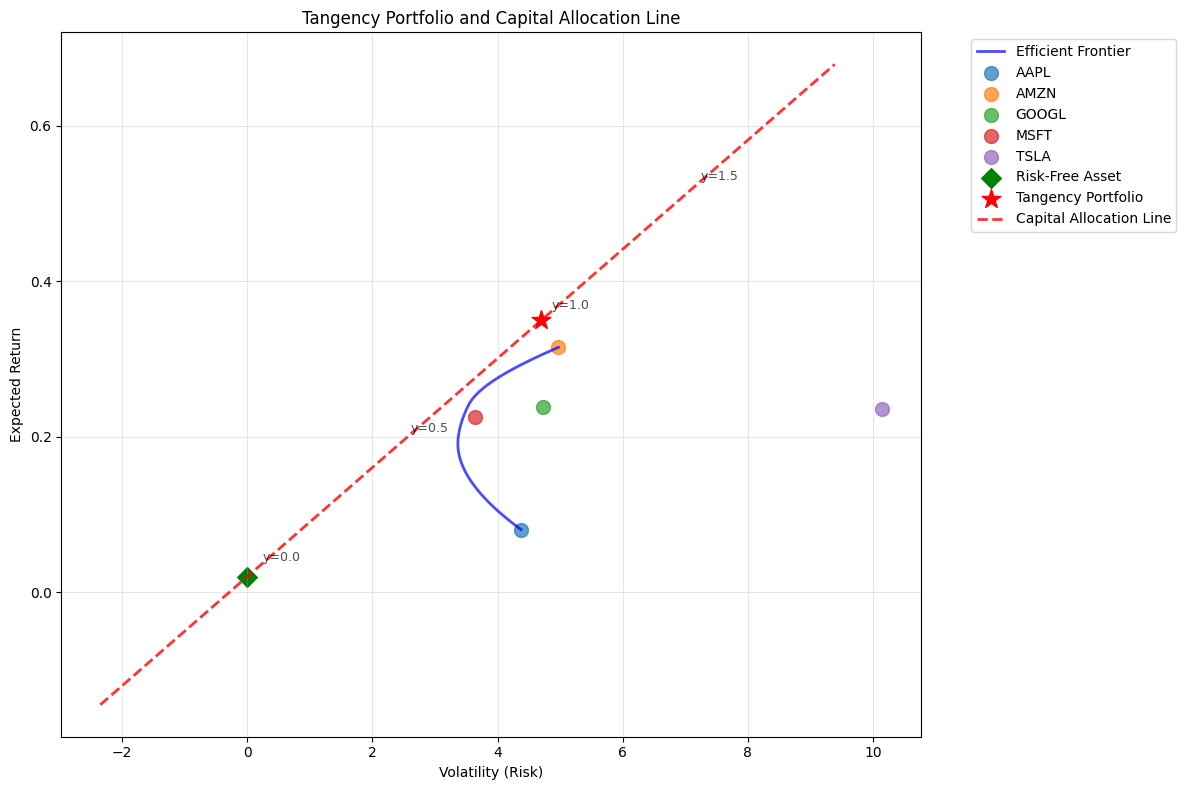


TANGENCY PORTFOLIO ANALYSIS

Risk-Free Rate: 0.0200
Expected Return: 0.3493
Volatility: 4.6940
Sharpe Ratio: 0.0702
Excess Return: 0.3293

Portfolio Weights (analytical):
  AAPL: -0.5020 (SHORT)
  AMZN: 0.5372 (LONG)
  GOOGL: 0.2516 (LONG)
  MSFT: 0.7472 (LONG)
  TSLA: -0.0339 (SHORT)

Total Weight: 1.000000


COMPARISON: Analytical vs Optimization
----------------------------------------
Analytical Sharpe Ratio: 0.070156
Optimization Sharpe Ratio: 0.070149
Difference: 0.000008

LEVERAGE ANALYSIS
y = weight in risky portfolio
1-y = weight in risk-free asset
------------------------------------------------------------
y = 0.0 (100% Risk-Free)
  Expected Return: 0.0200
  Volatility: 0.0000
  Sharpe Ratio: 0.0000

y = 0.5 (Conservative)
  Expected Return: 0.1847
  Volatility: 2.3470
  Sharpe Ratio: 0.0702

y = 1.0 (100% Risky)
  Expected Return: 0.3493
  Volatility: 4.6940
  Sharpe Ratio: 0.0702

y = 1.5 (Leveraged)
  Expected Return: 0.5140
  Volatility: 7.0410
  Sharpe Ratio: 0.0702

y

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

class TangencyPortfolio:
    def __init__(self, returns, risk_free_rate=0.02):
        """
        Initialize tangency portfolio with returns data
        
        Parameters:
        returns: DataFrame of asset returns
        risk_free_rate: Risk-free rate (default 2%)
        """
        self.returns = returns
        self.mean_returns = returns.mean()
        self.cov_matrix = returns.cov()
        self.risk_free_rate = risk_free_rate
        self.n_assets = len(returns.columns)
        self.asset_names = returns.columns.tolist()
    
    def portfolio_stats(self, weights):
        """
        Calculate portfolio return, volatility, and Sharpe ratio
        """
        portfolio_return = np.sum(weights * self.mean_returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(self.cov_matrix, weights)))
        sharpe_ratio = (portfolio_return - self.risk_free_rate) / portfolio_volatility
        return portfolio_return, portfolio_volatility, sharpe_ratio
    
    def negative_sharpe_ratio(self, weights):
        """
        Calculate negative Sharpe ratio (for minimization)
        """
        _, _, sharpe = self.portfolio_stats(weights)
        return -sharpe
    
    def tangency_portfolio_analytical(self):
        """
        Calculate tangency portfolio using analytical solution
        """
        # Excess returns
        excess_returns = self.mean_returns - self.risk_free_rate
        
        # Calculate optimal weights using analytical formula
        # w = (Σ^-1 * μ_excess) / (1' * Σ^-1 * μ_excess)
        inv_cov = np.linalg.inv(self.cov_matrix)
        numerator = np.dot(inv_cov, excess_returns)
        denominator = np.dot(np.ones(self.n_assets), numerator)
        
        weights = numerator / denominator
        
        # Calculate portfolio statistics
        portfolio_return, portfolio_volatility, sharpe_ratio = self.portfolio_stats(weights)
        
        return {
            'weights': weights,
            'expected_return': portfolio_return,
            'volatility': portfolio_volatility,
            'sharpe_ratio': sharpe_ratio,
            'method': 'analytical'
        }
    
    def tangency_portfolio_optimization(self, allow_short_selling=True):
        """
        Calculate tangency portfolio using numerical optimization
        """
        # Constraints
        constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
        
        # Bounds
        if allow_short_selling:
            bounds = tuple((-2, 2) for _ in range(self.n_assets))  # Allow short selling
        else:
            bounds = tuple((0, 1) for _ in range(self.n_assets))   # Long only
        
        # Initial guess
        x0 = np.array([1/self.n_assets] * self.n_assets)
        
        # Optimize
        result = minimize(
            self.negative_sharpe_ratio,
            x0,
            method='SLSQP',
            bounds=bounds,
            constraints=constraints,
            options={'disp': False}
        )
        
        if result.success:
            weights = result.x
            portfolio_return, portfolio_volatility, sharpe_ratio = self.portfolio_stats(weights)
            
            return {
                'weights': weights,
                'expected_return': portfolio_return,
                'volatility': portfolio_volatility,
                'sharpe_ratio': sharpe_ratio,
                'method': 'optimization'
            }
        else:
            return None
    
    def capital_allocation_line(self, tangency_portfolio, leverage_range=(-0.5, 2.0)):
        """
        Generate points for the Capital Allocation Line (CAL)
        """
        # Weight in risky portfolio (tangency portfolio)
        y_values = np.linspace(leverage_range[0], leverage_range[1], 100)
        
        cal_returns = []
        cal_volatilities = []
        
        for y in y_values:
            # Portfolio return: y * r_p + (1-y) * r_f
            port_return = y * tangency_portfolio['expected_return'] + (1-y) * self.risk_free_rate
            # Portfolio volatility: y * σ_p
            port_volatility = y * tangency_portfolio['volatility']
            
            cal_returns.append(port_return)
            cal_volatilities.append(port_volatility)
        
        return cal_volatilities, cal_returns, y_values
    
    def efficient_frontier(self, n_points=50):
        """
        Generate efficient frontier for comparison
        """
        min_ret = self.mean_returns.min()
        max_ret = self.mean_returns.max()
        target_returns = np.linspace(min_ret, max_ret, n_points)
        
        efficient_portfolios = []
        
        for target_return in target_returns:
            # Minimize volatility subject to target return
            def portfolio_volatility(weights):
                return np.sqrt(np.dot(weights.T, np.dot(self.cov_matrix, weights)))
            
            constraints = [
                {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                {'type': 'eq', 'fun': lambda x: np.sum(x * self.mean_returns) - target_return}
            ]
            
            bounds = tuple((0, 1) for _ in range(self.n_assets))
            x0 = np.array([1/self.n_assets] * self.n_assets)
            
            result = minimize(
                portfolio_volatility,
                x0,
                method='SLSQP',
                bounds=bounds,
                constraints=constraints,
                options={'disp': False}
            )
            
            if result.success:
                vol = result.fun
                efficient_portfolios.append([vol, target_return])
        
        return efficient_portfolios
    
    def plot_tangency_portfolio(self, show_efficient_frontier=True):
        """
        Plot tangency portfolio with Capital Allocation Line
        """
        # Calculate tangency portfolio
        tangency_analytical = self.tangency_portfolio_analytical()
        tangency_optimization = self.tangency_portfolio_optimization()
        
        # Generate CAL
        cal_vols, cal_rets, y_values = self.capital_allocation_line(tangency_analytical)
        
        # Create plot
        plt.figure(figsize=(12, 8))
        
        # Plot efficient frontier if requested
        if show_efficient_frontier:
            efficient_portfolios = self.efficient_frontier()
            if efficient_portfolios:
                ef_vols = [p[0] for p in efficient_portfolios]
                ef_rets = [p[1] for p in efficient_portfolios]
                plt.plot(ef_vols, ef_rets, 'b-', linewidth=2, alpha=0.7, label='Efficient Frontier')
        
        # Plot individual assets
        for i, asset in enumerate(self.asset_names):
            ret = self.mean_returns[asset]
            vol = np.sqrt(self.cov_matrix.loc[asset, asset])
            plt.scatter(vol, ret, s=100, alpha=0.7, label=asset)
        
        # Plot risk-free asset
        plt.scatter(0, self.risk_free_rate, s=100, c='green', marker='D', label='Risk-Free Asset')
        
        # Plot tangency portfolio
        plt.scatter(tangency_analytical['volatility'], tangency_analytical['expected_return'], 
                   s=200, c='red', marker='*', label='Tangency Portfolio', zorder=5)
        
        # Plot Capital Allocation Line
        plt.plot(cal_vols, cal_rets, 'r--', linewidth=2, label='Capital Allocation Line', alpha=0.8)
        
        # Annotations for different leverage levels
        for i, y in enumerate([0, 0.5, 1.0, 1.5]):
            if 0 <= i < len(y_values):
                idx = np.argmin(np.abs(np.array(y_values) - y))
                if idx < len(cal_vols):
                    plt.annotate(f'y={y:.1f}', 
                               xy=(cal_vols[idx], cal_rets[idx]),
                               xytext=(10, 10), textcoords='offset points',
                               fontsize=9, alpha=0.7)
        
        plt.xlabel('Volatility (Risk)')
        plt.ylabel('Expected Return')
        plt.title('Tangency Portfolio and Capital Allocation Line')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        return tangency_analytical, tangency_optimization
    
    def print_portfolio_analysis(self, tangency_portfolio):
        """
        Print detailed portfolio analysis
        """
        print("\n" + "="*60)
        print("TANGENCY PORTFOLIO ANALYSIS")
        print("="*60)
        
        print(f"\nRisk-Free Rate: {self.risk_free_rate:.4f}")
        print(f"Expected Return: {tangency_portfolio['expected_return']:.4f}")
        print(f"Volatility: {tangency_portfolio['volatility']:.4f}")
        print(f"Sharpe Ratio: {tangency_portfolio['sharpe_ratio']:.4f}")
        print(f"Excess Return: {tangency_portfolio['expected_return'] - self.risk_free_rate:.4f}")
        
        print(f"\nPortfolio Weights ({tangency_portfolio['method']}):")
        for i, asset in enumerate(self.asset_names):
            weight = tangency_portfolio['weights'][i]
            status = "(SHORT)" if weight < 0 else "(LONG)"
            print(f"  {asset}: {weight:.4f} {status}")
        
        # Check if weights sum to 1
        total_weight = np.sum(tangency_portfolio['weights'])
        print(f"\nTotal Weight: {total_weight:.6f}")
        
        print("\n" + "="*60)
    
    def leverage_analysis(self, tangency_portfolio):
        """
        Analyze different leverage scenarios
        """
        print("\nLEVERAGE ANALYSIS")
        print("="*60)
        print("y = weight in risky portfolio")
        print("1-y = weight in risk-free asset")
        print("-"*60)
        
        leverage_scenarios = [0.0, 0.5, 1.0, 1.5, 2.0]
        
        for y in leverage_scenarios:
            port_return = y * tangency_portfolio['expected_return'] + (1-y) * self.risk_free_rate
            port_volatility = y * tangency_portfolio['volatility']
            
            if port_volatility > 0:
                port_sharpe = (port_return - self.risk_free_rate) / port_volatility
            else:
                port_sharpe = 0
            
            leverage_type = ""
            if y == 0:
                leverage_type = "(100% Risk-Free)"
            elif y < 1:
                leverage_type = "(Conservative)"
            elif y == 1:
                leverage_type = "(100% Risky)"
            else:
                leverage_type = "(Leveraged)"
            
            print(f"y = {y:.1f} {leverage_type}")
            print(f"  Expected Return: {port_return:.4f}")
            print(f"  Volatility: {port_volatility:.4f}")
            print(f"  Sharpe Ratio: {port_sharpe:.4f}")
            print()

def fetch_stock_data(tickers, period='2y'):
    """
    Fetch stock data and calculate returns
    """
    print(f"Fetching data for {tickers}...")
    data = yf.download(tickers, period=period)['Close']
    
    # Calculate returns
    returns = data.pct_change().dropna()
    
    # Annualize returns
    returns = returns * 252
    
    print(f"Data fetched successfully. Shape: {returns.shape}")
    return returns

def main():
    # Define parameters
    tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'TSLA']
    risk_free_rate = 0.02  # 2% annual risk-free rate
    
    # Fetch data
    returns = fetch_stock_data(tickers, period='2y')
    
    # Create tangency portfolio object
    tp = TangencyPortfolio(returns, risk_free_rate)
    
    # Print basic statistics
    print("\n" + "="*60)
    print("ASSET STATISTICS")
    print("="*60)
    print("\nAnnualized Returns:")
    for ticker in tickers:
        print(f"{ticker}: {tp.mean_returns[ticker]:.4f}")
    
    print("\nAnnualized Volatilities:")
    for ticker in tickers:
        vol = np.sqrt(tp.cov_matrix.loc[ticker, ticker])
        print(f"{ticker}: {vol:.4f}")
    
    print("\nSharpe Ratios:")
    for ticker in tickers:
        ret = tp.mean_returns[ticker]
        vol = np.sqrt(tp.cov_matrix.loc[ticker, ticker])
        sharpe = (ret - risk_free_rate) / vol
        print(f"{ticker}: {sharpe:.4f}")
    
    # Calculate and plot tangency portfolio
    tangency_analytical, tangency_optimization = tp.plot_tangency_portfolio()
    
    # Print analysis
    tp.print_portfolio_analysis(tangency_analytical)
    
    # Compare analytical vs optimization results
    if tangency_optimization:
        print("\nCOMPARISON: Analytical vs Optimization")
        print("-"*40)
        print(f"Analytical Sharpe Ratio: {tangency_analytical['sharpe_ratio']:.6f}")
        print(f"Optimization Sharpe Ratio: {tangency_optimization['sharpe_ratio']:.6f}")
        print(f"Difference: {abs(tangency_analytical['sharpe_ratio'] - tangency_optimization['sharpe_ratio']):.6f}")
    
    # Leverage analysis
    tp.leverage_analysis(tangency_analytical)
    
    # Print correlation matrix
    print("\nCORRELATION MATRIX")
    print("="*60)
    correlation_matrix = returns.corr()
    print(correlation_matrix.round(4))

if __name__ == "__main__":
    main()

Fetching data for ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'TSLA', 'JPM', 'JNJ', 'V']...


[*********************100%***********************]  8 of 8 completed


Data fetched successfully. Shape: (500, 8)


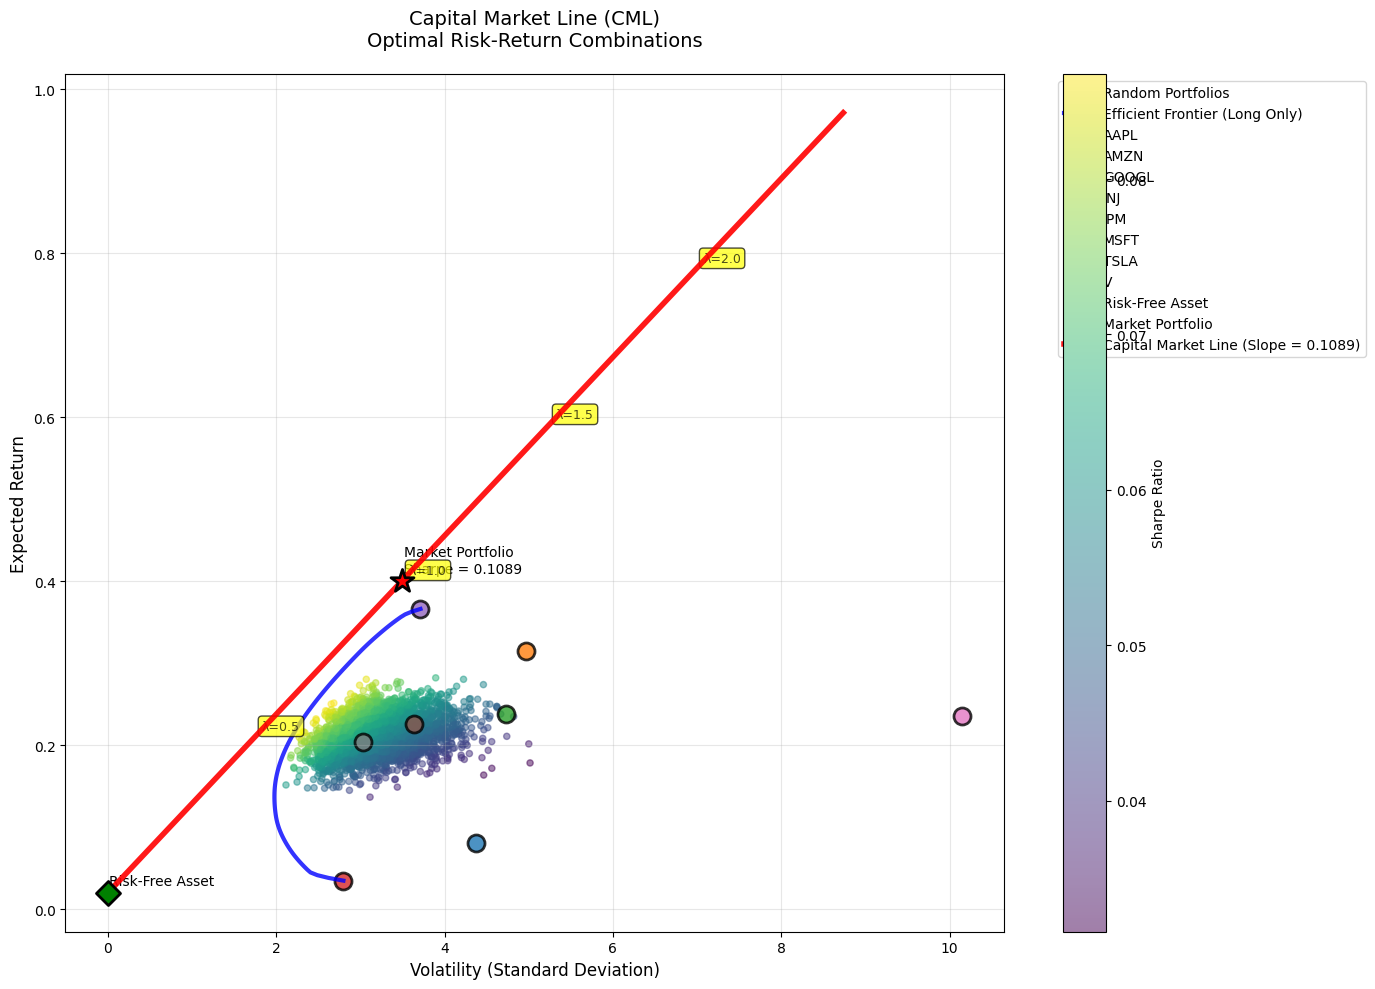


CAPITAL MARKET LINE ANALYSIS

Risk-Free Rate: 0.0200 (2.00%)

MARKET PORTFOLIO:
  Expected Return: 0.4006 (40.06%)
  Volatility: 3.4948 (349.48%)
  Sharpe Ratio: 0.1089
  Excess Return: 0.3806

CAPITAL MARKET LINE:
  Equation: E(r) = 0.0200 + 0.1089 × σ
  Slope (Market Price of Risk): 0.1089
  Interpretation: 0.1089 excess return per unit of risk

MARKET PORTFOLIO WEIGHTS:
  AAPL: -0.3358 (-33.58%)
  AMZN: 0.1188 (11.88%)
  GOOGL: 0.1094 (10.94%)
  JNJ: -0.0846 (-8.46%)
  JPM: 0.7403 (74.03%)
  MSFT: 0.3019 (30.19%)
  TSLA: -0.0846 (-8.46%)
  V: 0.2346 (23.46%)
  Total Weight: 1.000000

LEVERAGE SCENARIOS:
  λ = proportion invested in market portfolio
  (1-λ) = proportion invested in risk-free asset
  λ > 1 indicates borrowing at risk-free rate

  λ     E(r)     σ        Sharpe   Description
  --------------------------------------------------
  0.0   0.0200   0.0000   0.0000   100% Risk-Free
  0.5   0.2103   1.7474   0.1089   50% Risky, 50% Risk-Free
  1.0   0.4006   3.4948   0.1089 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

class CapitalMarketLine:
    def __init__(self, returns, risk_free_rate=0.02):
        """
        Initialize Capital Market Line analysis
        
        Parameters:
        returns: DataFrame of asset returns
        risk_free_rate: Risk-free rate (default 2%)
        """
        self.returns = returns
        self.mean_returns = returns.mean()
        self.cov_matrix = returns.cov()
        self.risk_free_rate = risk_free_rate
        self.n_assets = len(returns.columns)
        self.asset_names = returns.columns.tolist()
    
    def portfolio_stats(self, weights):
        """
        Calculate portfolio return, volatility, and Sharpe ratio
        """
        portfolio_return = np.sum(weights * self.mean_returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(self.cov_matrix, weights)))
        sharpe_ratio = (portfolio_return - self.risk_free_rate) / portfolio_volatility
        return portfolio_return, portfolio_volatility, sharpe_ratio
    
    def find_market_portfolio(self):
        """
        Find the market portfolio (tangency portfolio) - the portfolio with maximum Sharpe ratio
        """
        # Analytical solution for tangency portfolio
        excess_returns = self.mean_returns - self.risk_free_rate
        inv_cov = np.linalg.inv(self.cov_matrix)
        numerator = np.dot(inv_cov, excess_returns)
        denominator = np.dot(np.ones(self.n_assets), numerator)
        
        weights = numerator / denominator
        portfolio_return, portfolio_volatility, sharpe_ratio = self.portfolio_stats(weights)
        
        return {
            'weights': weights,
            'expected_return': portfolio_return,
            'volatility': portfolio_volatility,
            'sharpe_ratio': sharpe_ratio
        }
    
    def efficient_frontier(self, n_points=100):
        """
        Generate efficient frontier points (long-only portfolios)
        """
        min_ret = self.mean_returns.min()
        max_ret = self.mean_returns.max()
        target_returns = np.linspace(min_ret, max_ret, n_points)
        
        efficient_portfolios = []
        
        for target_return in target_returns:
            def portfolio_volatility(weights):
                return np.sqrt(np.dot(weights.T, np.dot(self.cov_matrix, weights)))
            
            constraints = [
                {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                {'type': 'eq', 'fun': lambda x: np.sum(x * self.mean_returns) - target_return}
            ]
            
            bounds = tuple((0, 1) for _ in range(self.n_assets))
            x0 = np.array([1/self.n_assets] * self.n_assets)
            
            result = minimize(
                portfolio_volatility,
                x0,
                method='SLSQP',
                bounds=bounds,
                constraints=constraints,
                options={'disp': False}
            )
            
            if result.success and result.fun > 0:
                efficient_portfolios.append([result.fun, target_return])
        
        return efficient_portfolios
    
    def capital_market_line_points(self, market_portfolio, max_volatility=None):
        """
        Generate points along the Capital Market Line
        """
        if max_volatility is None:
            max_volatility = market_portfolio['volatility'] * 2.5
        
        # Generate volatility range from 0 to max_volatility
        volatilities = np.linspace(0, max_volatility, 100)
        
        # CML equation: E(r) = rf + [(E(rm) - rf) / σm] * σp
        # Where σp is the portfolio volatility
        market_excess_return = market_portfolio['expected_return'] - self.risk_free_rate
        market_volatility = market_portfolio['volatility']
        
        # Slope of CML (market price of risk)
        cml_slope = market_excess_return / market_volatility
        
        # Calculate returns along CML
        cml_returns = self.risk_free_rate + cml_slope * volatilities
        
        return volatilities, cml_returns, cml_slope
    
    def generate_random_portfolios(self, n_portfolios=5000):
        """
        Generate random portfolios for visualization
        """
        random_portfolios = []
        
        for _ in range(n_portfolios):
            # Generate random weights
            weights = np.random.random(self.n_assets)
            weights = weights / np.sum(weights)  # Normalize to sum to 1
            
            # Calculate portfolio statistics
            portfolio_return, portfolio_volatility, sharpe_ratio = self.portfolio_stats(weights)
            
            random_portfolios.append({
                'return': portfolio_return,
                'volatility': portfolio_volatility,
                'sharpe_ratio': sharpe_ratio,
                'weights': weights
            })
        
        return random_portfolios
    
    def plot_capital_market_line(self, show_efficient_frontier=True, show_random_portfolios=True):
        """
        Plot the Capital Market Line with various portfolio types
        """
        # Find market portfolio
        market_portfolio = self.find_market_portfolio()
        
        # Generate CML points
        cml_vols, cml_returns, cml_slope = self.capital_market_line_points(market_portfolio)
        
        # Create the plot
        plt.figure(figsize=(14, 10))
        
        # Plot random portfolios if requested
        if show_random_portfolios:
            random_portfolios = self.generate_random_portfolios(3000)
            random_vols = [p['volatility'] for p in random_portfolios]
            random_rets = [p['return'] for p in random_portfolios]
            random_sharpes = [p['sharpe_ratio'] for p in random_portfolios]
            
            # Color by Sharpe ratio
            scatter = plt.scatter(random_vols, random_rets, c=random_sharpes, alpha=0.5, 
                                s=20, cmap='viridis', label='Random Portfolios')
            plt.colorbar(scatter, label='Sharpe Ratio')
        
        # Plot efficient frontier if requested
        if show_efficient_frontier:
            efficient_portfolios = self.efficient_frontier()
            if efficient_portfolios:
                ef_vols = [p[0] for p in efficient_portfolios]
                ef_rets = [p[1] for p in efficient_portfolios]
                plt.plot(ef_vols, ef_rets, 'b-', linewidth=3, alpha=0.8, 
                        label='Efficient Frontier (Long Only)')
        
        # Plot individual assets
        for i, asset in enumerate(self.asset_names):
            ret = self.mean_returns[asset]
            vol = np.sqrt(self.cov_matrix.loc[asset, asset])
            plt.scatter(vol, ret, s=150, alpha=0.8, marker='o', 
                       edgecolors='black', linewidth=2, label=asset)
        
        # Plot risk-free asset
        plt.scatter(0, self.risk_free_rate, s=150, c='green', marker='D', 
                   edgecolors='black', linewidth=2, label='Risk-Free Asset', zorder=5)
        
        # Plot market portfolio
        plt.scatter(market_portfolio['volatility'], market_portfolio['expected_return'], 
                   s=300, c='red', marker='*', edgecolors='black', linewidth=2,
                   label='Market Portfolio', zorder=6)
        
        # Plot Capital Market Line
        plt.plot(cml_vols, cml_returns, 'r-', linewidth=4, alpha=0.9, 
                label=f'Capital Market Line (Slope = {cml_slope:.4f})', zorder=4)
        
        # Add annotations for key points
        plt.annotate('Risk-Free Asset', xy=(0, self.risk_free_rate), 
                    xytext=(0.01, self.risk_free_rate + 0.01),
                    fontsize=10, ha='left')
        
        plt.annotate(f'Market Portfolio\nSharpe = {market_portfolio["sharpe_ratio"]:.4f}', 
                    xy=(market_portfolio['volatility'], market_portfolio['expected_return']), 
                    xytext=(market_portfolio['volatility'] + 0.02, market_portfolio['expected_return'] + 0.01),
                    fontsize=10, ha='left')
        
        # Add leverage annotations along CML
        leverage_points = [0.5, 1.0, 1.5, 2.0]
        for lev in leverage_points:
            vol_point = lev * market_portfolio['volatility']
            ret_point = self.risk_free_rate + cml_slope * vol_point
            if vol_point <= max(cml_vols):
                plt.annotate(f'λ={lev}', xy=(vol_point, ret_point), 
                           xytext=(5, 5), textcoords='offset points',
                           fontsize=9, alpha=0.7, 
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
        
        plt.xlabel('Volatility (Standard Deviation)', fontsize=12)
        plt.ylabel('Expected Return', fontsize=12)
        plt.title('Capital Market Line (CML)\nOptimal Risk-Return Combinations', fontsize=14, pad=20)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        return market_portfolio, cml_slope
    
    def print_cml_analysis(self, market_portfolio, cml_slope):
        """
        Print detailed Capital Market Line analysis
        """
        print("\n" + "="*70)
        print("CAPITAL MARKET LINE ANALYSIS")
        print("="*70)
        
        print(f"\nRisk-Free Rate: {self.risk_free_rate:.4f} ({self.risk_free_rate*100:.2f}%)")
        
        print(f"\nMARKET PORTFOLIO:")
        print(f"  Expected Return: {market_portfolio['expected_return']:.4f} ({market_portfolio['expected_return']*100:.2f}%)")
        print(f"  Volatility: {market_portfolio['volatility']:.4f} ({market_portfolio['volatility']*100:.2f}%)")
        print(f"  Sharpe Ratio: {market_portfolio['sharpe_ratio']:.4f}")
        print(f"  Excess Return: {market_portfolio['expected_return'] - self.risk_free_rate:.4f}")
        
        print(f"\nCAPITAL MARKET LINE:")
        print(f"  Equation: E(r) = {self.risk_free_rate:.4f} + {cml_slope:.4f} × σ")
        print(f"  Slope (Market Price of Risk): {cml_slope:.4f}")
        print(f"  Interpretation: {cml_slope:.4f} excess return per unit of risk")
        
        print(f"\nMARKET PORTFOLIO WEIGHTS:")
        for i, asset in enumerate(self.asset_names):
            weight = market_portfolio['weights'][i]
            print(f"  {asset}: {weight:.4f} ({weight*100:.2f}%)")
        
        total_weight = np.sum(market_portfolio['weights'])
        print(f"  Total Weight: {total_weight:.6f}")
        
        print(f"\nLEVERAGE SCENARIOS:")
        print(f"  λ = proportion invested in market portfolio")
        print(f"  (1-λ) = proportion invested in risk-free asset")
        print(f"  λ > 1 indicates borrowing at risk-free rate")
        
        leverage_scenarios = [0.0, 0.5, 1.0, 1.5, 2.0]
        print(f"\n  {'λ':<5} {'E(r)':<8} {'σ':<8} {'Sharpe':<8} {'Description'}")
        print(f"  {'-'*50}")
        
        for lam in leverage_scenarios:
            port_return = self.risk_free_rate + lam * (market_portfolio['expected_return'] - self.risk_free_rate)
            port_volatility = lam * market_portfolio['volatility']
            
            if port_volatility > 0:
                port_sharpe = (port_return - self.risk_free_rate) / port_volatility
            else:
                port_sharpe = 0
            
            if lam == 0:
                desc = "100% Risk-Free"
            elif lam < 1:
                desc = f"{lam*100:.0f}% Risky, {(1-lam)*100:.0f}% Risk-Free"
            elif lam == 1:
                desc = "100% Market Portfolio"
            else:
                desc = f"Leveraged ({(lam-1)*100:.0f}% borrowed)"
            
            print(f"  {lam:<5.1f} {port_return:<8.4f} {port_volatility:<8.4f} {port_sharpe:<8.4f} {desc}")
        
        print("\n" + "="*70)
    
    def cml_vs_individual_assets(self, market_portfolio, cml_slope):
        """
        Compare CML with individual asset performance
        """
        print(f"\nCML vs INDIVIDUAL ASSETS COMPARISON")
        print("="*70)
        print(f"{'Asset':<8} {'Return':<8} {'Volatility':<10} {'Sharpe':<8} {'CML Return':<12} {'Difference'}")
        print("-"*70)
        
        for asset in self.asset_names:
            asset_return = self.mean_returns[asset]
            asset_vol = np.sqrt(self.cov_matrix.loc[asset, asset])
            asset_sharpe = (asset_return - self.risk_free_rate) / asset_vol
            
            # Expected return on CML for same volatility
            cml_return = self.risk_free_rate + cml_slope * asset_vol
            difference = asset_return - cml_return
            
            print(f"{asset:<8} {asset_return:<8.4f} {asset_vol:<10.4f} {asset_sharpe:<8.4f} {cml_return:<12.4f} {difference:<8.4f}")
        
        print(f"\nInterpretation:")
        print(f"- Positive difference: Asset performs better than CML prediction")
        print(f"- Negative difference: Asset underperforms CML prediction")
        print(f"- Only efficient portfolios should lie on the CML")

def fetch_stock_data(tickers, period='2y'):
    """
    Fetch stock data and calculate returns
    """
    print(f"Fetching data for {tickers}...")
    data = yf.download(tickers, period=period)['Close']
    returns = data.pct_change().dropna()
    returns = returns * 252  # Annualize
    print(f"Data fetched successfully. Shape: {returns.shape}")
    return returns

def main():
    # Define parameters
    tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'TSLA', 'JPM', 'JNJ', 'V']
    risk_free_rate = 0.02  # 2% annual risk-free rate
    
    # Fetch data
    returns = fetch_stock_data(tickers, period='2y')
    
    # Create CML object
    cml = CapitalMarketLine(returns, risk_free_rate)
    
    # Generate and plot CML
    market_portfolio, cml_slope = cml.plot_capital_market_line(
        show_efficient_frontier=True, 
        show_random_portfolios=True
    )
    
    # Print detailed analysis
    cml.print_cml_analysis(market_portfolio, cml_slope)
    
    # Compare with individual assets
    cml.cml_vs_individual_assets(market_portfolio, cml_slope)
    
    # Print correlation matrix
    print(f"\nCORRELATION MATRIX")
    print("="*50)
    correlation_matrix = returns.corr()
    print(correlation_matrix.round(3))

if __name__ == "__main__":
    main()

Fetching data for ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'TSLA', 'SPY']...


[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  1 of 1 completed


Data fetched successfully. Stocks shape: (500, 5), Market shape: (500, 1)
Stock returns shape: (500, 5)
Market returns shape: (500,)
Stock returns type: <class 'pandas.core.frame.DataFrame'>
Market returns type: <class 'pandas.core.series.Series'>


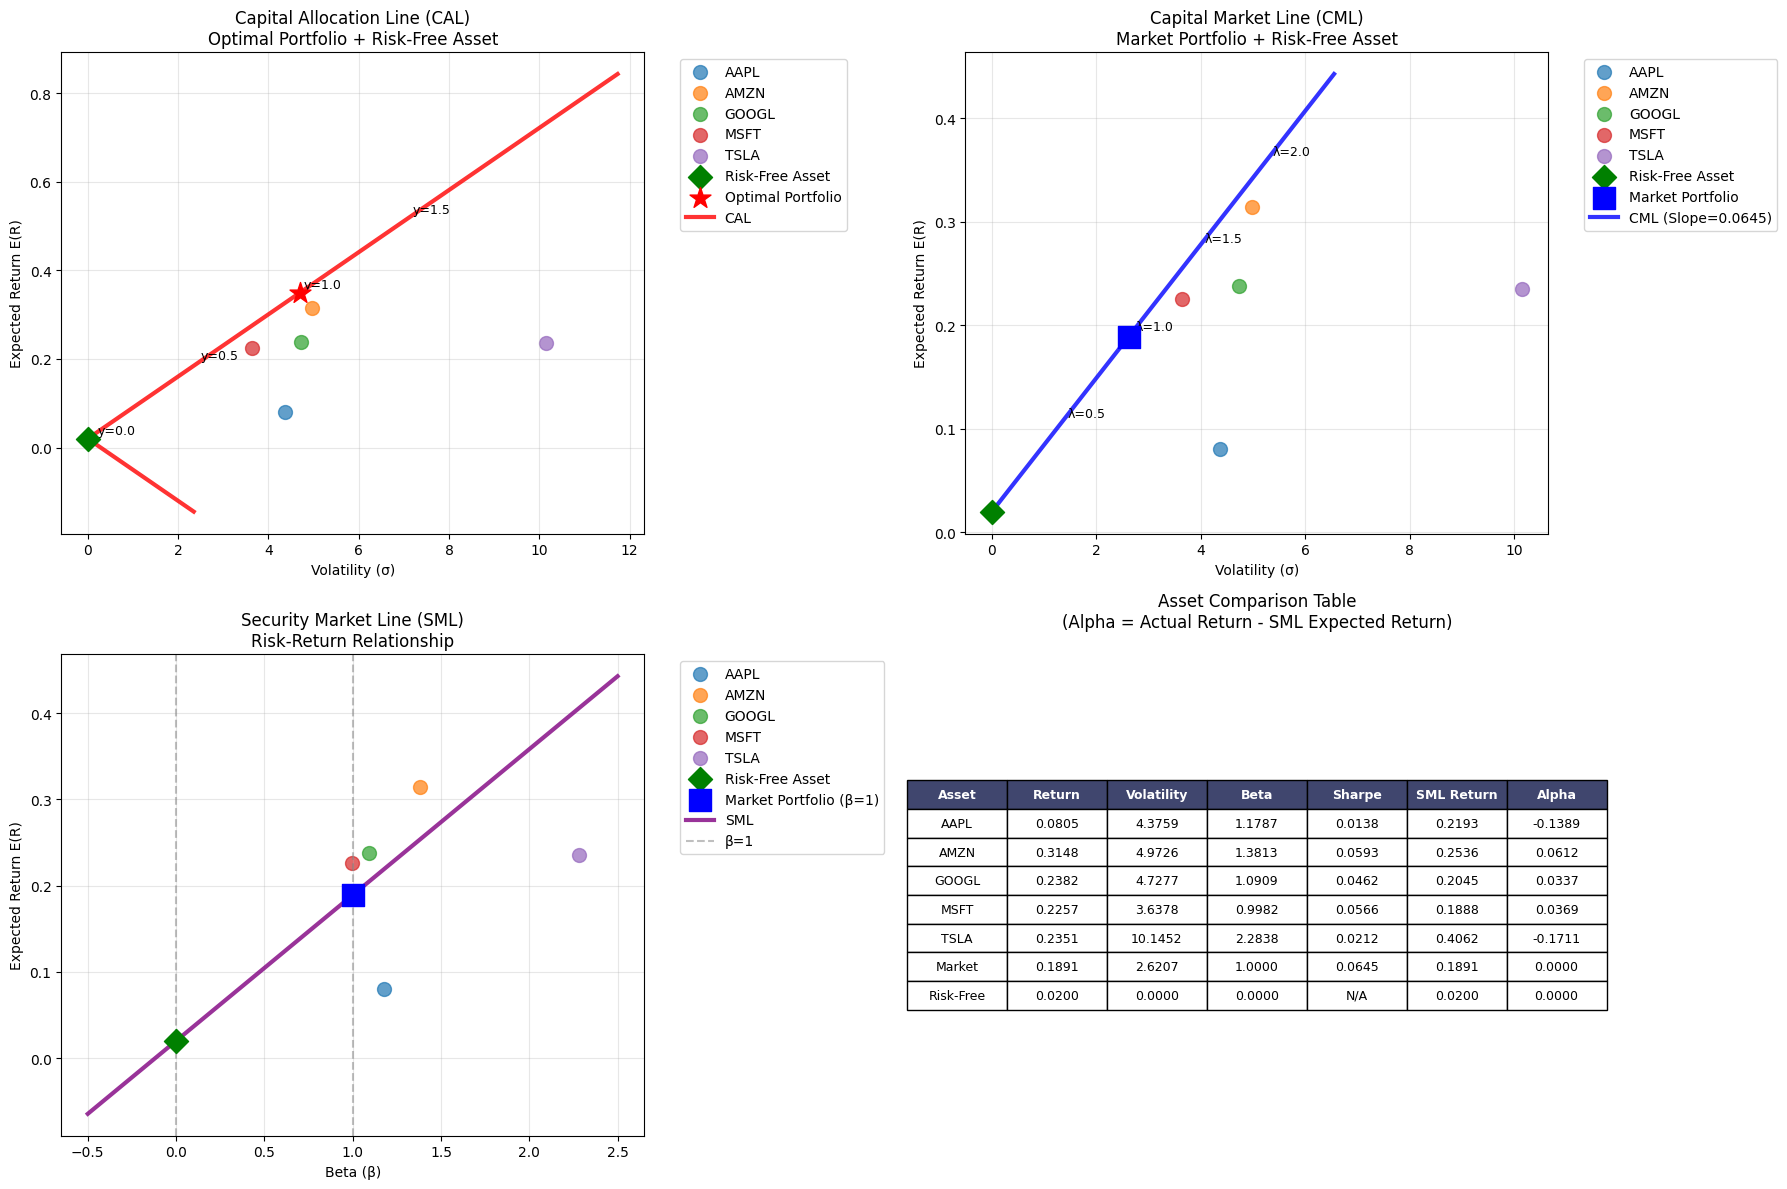


COMPREHENSIVE ANALYSIS: CAL, CML, and SML

1. CAPITAL ALLOCATION LINE (CAL)
----------------------------------------
Definition: Shows risk-return combinations by mixing ANY risky portfolio
            with the risk-free asset
Equation: E(rp) = (1-y)×rf + y×E(ropt)
         σp = y×σopt
Where: y = weight in risky portfolio, (1-y) = weight in risk-free asset

Optimal Portfolio Statistics:
  Expected Return: 0.3493
  Volatility: 4.6940
  Sharpe Ratio: 0.0702

Optimal Portfolio Weights:
  AAPL: -0.5020
  AMZN: 0.5372
  GOOGL: 0.2516
  MSFT: 0.7472
  TSLA: -0.0339

2. CAPITAL MARKET LINE (CML)
----------------------------------------
Definition: Shows risk-return combinations by mixing the MARKET portfolio
            with the risk-free asset
Equation: E(rp) = rf + [(E(rm)-rf)/σm] × σp
         E(rp) = 0.0200 + 0.0645 × σp
Slope (Market Price of Risk): 0.0645

Market Portfolio Statistics:
  Expected Return: 0.1891
  Volatility: 2.6207
  Excess Return: 0.1691

3. SECURITY MARKET LINE (SML)


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy import stats
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

class PortfolioAnalysis:
    def __init__(self, returns, market_returns=None, risk_free_rate=0.02):
        """
        Initialize portfolio analysis with returns data
        
        Parameters:
        returns: DataFrame of asset returns
        market_returns: Series of market returns (if None, will create equal-weighted portfolio)
        risk_free_rate: Risk-free rate (default 2%)
        """
        self.returns = returns
        self.mean_returns = returns.mean()
        self.cov_matrix = returns.cov()
        self.risk_free_rate = risk_free_rate
        self.n_assets = len(returns.columns)
        self.asset_names = returns.columns.tolist()
        
        # Market returns - if not provided, create equal-weighted portfolio
        if market_returns is None:
            self.market_returns = returns.mean(axis=1)
        else:
            # Ensure market_returns is a Series with proper index alignment
            if isinstance(market_returns, pd.DataFrame):
                market_returns = market_returns.iloc[:, 0]
            self.market_returns = market_returns
        
        # Align data to common dates
        common_index = self.returns.index.intersection(self.market_returns.index)
        if len(common_index) == 0:
            raise ValueError("No common dates found between returns and market_returns")
        
        self.returns = self.returns.loc[common_index]
        self.market_returns = self.market_returns.loc[common_index]
        
        # Recalculate statistics with aligned data
        self.mean_returns = self.returns.mean()
        self.cov_matrix = self.returns.cov()
        
        self.market_mean_return = self.market_returns.mean()
        self.market_volatility = self.market_returns.std()
        
        # Calculate betas for each asset
        self.betas = self.calculate_betas()
    
    def portfolio_stats(self, weights):
        """Calculate portfolio return, volatility, and Sharpe ratio"""
        portfolio_return = np.sum(weights * self.mean_returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(self.cov_matrix, weights)))
        sharpe_ratio = (portfolio_return - self.risk_free_rate) / portfolio_volatility
        return portfolio_return, portfolio_volatility, sharpe_ratio
    
    def calculate_betas(self):
        """Calculate beta for each asset relative to market"""
        betas = {}
        
        for asset in self.asset_names:
            # Get asset and market data (already aligned in __init__)
            asset_data = self.returns[asset]
            market_data = self.market_returns
            
            # Calculate covariance manually to avoid dimension issues
            asset_mean = asset_data.mean()
            market_mean = market_data.mean()
            
            covariance = np.mean((asset_data - asset_mean) * (market_data - market_mean))
            market_variance = np.mean((market_data - market_mean) ** 2)
            
            beta = covariance / market_variance if market_variance != 0 else 0
            betas[asset] = beta
        
        return betas
    
    def find_optimal_portfolio(self, allow_short_selling=True):
        """Find the optimal risky portfolio (tangency portfolio)"""
        # Analytical solution for tangency portfolio
        excess_returns = self.mean_returns - self.risk_free_rate
        
        try:
            inv_cov = np.linalg.inv(self.cov_matrix)
            numerator = np.dot(inv_cov, excess_returns)
            denominator = np.dot(np.ones(self.n_assets), numerator)
            
            weights = numerator / denominator
        except np.linalg.LinAlgError:
            # Fallback to numerical optimization if matrix is singular
            weights = self.optimize_portfolio_numerically()
        
        portfolio_return, portfolio_volatility, sharpe_ratio = self.portfolio_stats(weights)
        
        return {
            'weights': weights,
            'expected_return': portfolio_return,
            'volatility': portfolio_volatility,
            'sharpe_ratio': sharpe_ratio
        }
    
    def optimize_portfolio_numerically(self):
        """Numerical optimization fallback for optimal portfolio"""
        def objective(weights):
            port_return, port_vol, sharpe = self.portfolio_stats(weights)
            return -sharpe  # Minimize negative Sharpe ratio
        
        constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
        bounds = tuple((-1, 1) for _ in range(self.n_assets))  # Allow short selling
        
        result = minimize(objective, 
                         x0=np.ones(self.n_assets) / self.n_assets,
                         method='SLSQP',
                         bounds=bounds,
                         constraints=constraints)
        
        return result.x
    
    def generate_cal_points(self, optimal_portfolio, leverage_range=(-0.5, 2.5)):
        """Generate Capital Allocation Line points"""
        y_values = np.linspace(leverage_range[0], leverage_range[1], 100)
        cal_returns = []
        cal_volatilities = []
        
        for y in y_values:
            port_return = y * optimal_portfolio['expected_return'] + (1-y) * self.risk_free_rate
            port_volatility = abs(y) * optimal_portfolio['volatility']  # abs for negative leverage
            cal_returns.append(port_return)
            cal_volatilities.append(port_volatility)
        
        return cal_volatilities, cal_returns, y_values
    
    def generate_cml_points(self, max_volatility=None):
        """Generate Capital Market Line points"""
        if max_volatility is None:
            max_volatility = self.market_volatility * 2.5
        
        volatilities = np.linspace(0, max_volatility, 100)
        market_excess_return = self.market_mean_return - self.risk_free_rate
        cml_slope = market_excess_return / self.market_volatility
        cml_returns = self.risk_free_rate + cml_slope * volatilities
        
        return volatilities, cml_returns, cml_slope
    
    def generate_sml_points(self, beta_range=(-0.5, 2.5)):
        """Generate Security Market Line points"""
        betas = np.linspace(beta_range[0], beta_range[1], 100)
        market_excess_return = self.market_mean_return - self.risk_free_rate
        sml_returns = self.risk_free_rate + betas * market_excess_return
        
        return betas, sml_returns
    
    def plot_cal_cml_sml(self):
        """Plot CAL, CML, and SML in separate subplots with explanations"""
        
        # Find optimal portfolio
        optimal_portfolio = self.find_optimal_portfolio()
        
        # Generate line points
        cal_vols, cal_returns, y_values = self.generate_cal_points(optimal_portfolio)
        cml_vols, cml_returns, cml_slope = self.generate_cml_points()
        sml_betas, sml_returns = self.generate_sml_points()
        
        # Create figure with subplots
        fig = plt.figure(figsize=(18, 12))
        
        # =================== CAL PLOT ===================
        ax1 = plt.subplot(2, 2, 1)
        
        # Plot individual assets
        for asset in self.asset_names:
            ret = self.mean_returns[asset]
            vol = np.sqrt(self.cov_matrix.loc[asset, asset])
            ax1.scatter(vol, ret, s=100, alpha=0.7, label=asset)
        
        # Plot risk-free asset
        ax1.scatter(0, self.risk_free_rate, s=150, c='green', marker='D', 
                   label='Risk-Free Asset', zorder=5)
        
        # Plot optimal portfolio
        ax1.scatter(optimal_portfolio['volatility'], optimal_portfolio['expected_return'], 
                   s=250, c='red', marker='*', label='Optimal Portfolio', zorder=6)
        
        # Plot CAL
        ax1.plot(cal_vols, cal_returns, 'r-', linewidth=3, alpha=0.8, label='CAL')
        
        # Add leverage annotations
        for i, y in enumerate([0, 0.5, 1.0, 1.5]):
            if i < len(y_values):
                idx = np.argmin(np.abs(np.array(y_values) - y))
                if idx < len(cal_vols):
                    ax1.annotate(f'y={y:.1f}', xy=(cal_vols[idx], cal_returns[idx]),
                               xytext=(5, 5), textcoords='offset points', fontsize=9)
        
        ax1.set_xlabel('Volatility (σ)')
        ax1.set_ylabel('Expected Return E(R)')
        ax1.set_title('Capital Allocation Line (CAL)\nOptimal Portfolio + Risk-Free Asset')
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax1.grid(True, alpha=0.3)
        
        # =================== CML PLOT ===================
        ax2 = plt.subplot(2, 2, 2)
        
        # Plot individual assets
        for asset in self.asset_names:
            ret = self.mean_returns[asset]
            vol = np.sqrt(self.cov_matrix.loc[asset, asset])
            ax2.scatter(vol, ret, s=100, alpha=0.7, label=asset)
        
        # Plot risk-free asset
        ax2.scatter(0, self.risk_free_rate, s=150, c='green', marker='D', 
                   label='Risk-Free Asset', zorder=5)
        
        # Plot market portfolio
        ax2.scatter(self.market_volatility, self.market_mean_return, 
                   s=250, c='blue', marker='s', label='Market Portfolio', zorder=6)
        
        # Plot CML
        ax2.plot(cml_vols, cml_returns, 'b-', linewidth=3, alpha=0.8, 
                label=f'CML (Slope={cml_slope:.4f})')
        
        # Add leverage annotations
        for lev in [0.5, 1.0, 1.5, 2.0]:
            vol_point = lev * self.market_volatility
            ret_point = self.risk_free_rate + cml_slope * vol_point
            if vol_point <= max(cml_vols):
                ax2.annotate(f'λ={lev}', xy=(vol_point, ret_point),
                           xytext=(5, 5), textcoords='offset points', fontsize=9)
        
        ax2.set_xlabel('Volatility (σ)')
        ax2.set_ylabel('Expected Return E(R)')
        ax2.set_title('Capital Market Line (CML)\nMarket Portfolio + Risk-Free Asset')
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax2.grid(True, alpha=0.3)
        
        # =================== SML PLOT ===================
        ax3 = plt.subplot(2, 2, 3)
        
        # Plot individual assets
        for asset in self.asset_names:
            ret = self.mean_returns[asset]
            beta = self.betas[asset]
            ax3.scatter(beta, ret, s=100, alpha=0.7, label=asset)
        
        # Plot risk-free asset
        ax3.scatter(0, self.risk_free_rate, s=150, c='green', marker='D', 
                   label='Risk-Free Asset', zorder=5)
        
        # Plot market portfolio
        ax3.scatter(1.0, self.market_mean_return, s=250, c='blue', marker='s', 
                   label='Market Portfolio (β=1)', zorder=6)
        
        # Plot SML
        ax3.plot(sml_betas, sml_returns, 'purple', linewidth=3, alpha=0.8, 
                label='SML')
        
        # Add beta annotations
        ax3.axvline(x=1.0, color='gray', linestyle='--', alpha=0.5, label='β=1')
        ax3.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
        
        ax3.set_xlabel('Beta (β)')
        ax3.set_ylabel('Expected Return E(R)')
        ax3.set_title('Security Market Line (SML)\nRisk-Return Relationship')
        ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax3.grid(True, alpha=0.3)
        
        # =================== COMPARISON TABLE ===================
        ax4 = plt.subplot(2, 2, 4)
        ax4.axis('off')
        
        # Create comparison table
        comparison_data = []
        for asset in self.asset_names:
            ret = self.mean_returns[asset]
            vol = np.sqrt(self.cov_matrix.loc[asset, asset])
            beta = self.betas[asset]
            sharpe = (ret - self.risk_free_rate) / vol if vol > 0 else 0
            sml_expected = self.risk_free_rate + beta * (self.market_mean_return - self.risk_free_rate)
            alpha = ret - sml_expected
            
            comparison_data.append([asset, f'{ret:.4f}', f'{vol:.4f}', f'{beta:.4f}', 
                                  f'{sharpe:.4f}', f'{sml_expected:.4f}', f'{alpha:.4f}'])
        
        # Add market and risk-free
        market_sharpe = (self.market_mean_return - self.risk_free_rate) / self.market_volatility
        comparison_data.append(['Market', f'{self.market_mean_return:.4f}', 
                              f'{self.market_volatility:.4f}', '1.0000', 
                              f'{market_sharpe:.4f}', f'{self.market_mean_return:.4f}', '0.0000'])
        comparison_data.append(['Risk-Free', f'{self.risk_free_rate:.4f}', '0.0000', 
                              '0.0000', 'N/A', f'{self.risk_free_rate:.4f}', '0.0000'])
        
        headers = ['Asset', 'Return', 'Volatility', 'Beta', 'Sharpe', 'SML Return', 'Alpha']
        
        table = ax4.table(cellText=comparison_data, colLabels=headers, loc='center', cellLoc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1.2, 1.5)
        
        # Color code the table
        for i in range(len(headers)):
            table[(0, i)].set_facecolor('#40466e')
            table[(0, i)].set_text_props(weight='bold', color='white')
        
        ax4.set_title('Asset Comparison Table\n(Alpha = Actual Return - SML Expected Return)', 
                     fontsize=12, pad=20)
        
        plt.tight_layout()
        plt.show()
        
        return optimal_portfolio, cml_slope
    
    def print_comprehensive_analysis(self, optimal_portfolio, cml_slope):
        """Print comprehensive analysis of CAL, CML, and SML"""
        
        print("\n" + "="*80)
        print("COMPREHENSIVE ANALYSIS: CAL, CML, and SML")
        print("="*80)
        
        # CAL Analysis
        print("\n1. CAPITAL ALLOCATION LINE (CAL)")
        print("-" * 40)
        print("Definition: Shows risk-return combinations by mixing ANY risky portfolio")
        print("            with the risk-free asset")
        print(f"Equation: E(rp) = (1-y)×rf + y×E(ropt)")
        print(f"         σp = y×σopt")
        print(f"Where: y = weight in risky portfolio, (1-y) = weight in risk-free asset")
        print(f"\nOptimal Portfolio Statistics:")
        print(f"  Expected Return: {optimal_portfolio['expected_return']:.4f}")
        print(f"  Volatility: {optimal_portfolio['volatility']:.4f}")
        print(f"  Sharpe Ratio: {optimal_portfolio['sharpe_ratio']:.4f}")
        
        print(f"\nOptimal Portfolio Weights:")
        for i, asset in enumerate(self.asset_names):
            print(f"  {asset}: {optimal_portfolio['weights'][i]:.4f}")
        
        # CML Analysis
        market_excess_return = self.market_mean_return - self.risk_free_rate
        print(f"\n2. CAPITAL MARKET LINE (CML)")
        print("-" * 40)
        print("Definition: Shows risk-return combinations by mixing the MARKET portfolio")
        print("            with the risk-free asset")
        print(f"Equation: E(rp) = rf + [(E(rm)-rf)/σm] × σp")
        print(f"         E(rp) = {self.risk_free_rate:.4f} + {cml_slope:.4f} × σp")
        print(f"Slope (Market Price of Risk): {cml_slope:.4f}")
        print(f"\nMarket Portfolio Statistics:")
        print(f"  Expected Return: {self.market_mean_return:.4f}")
        print(f"  Volatility: {self.market_volatility:.4f}")
        print(f"  Excess Return: {market_excess_return:.4f}")
        
        # SML Analysis
        print(f"\n3. SECURITY MARKET LINE (SML)")
        print("-" * 40)
        print("Definition: Shows required return for ANY asset based on its systematic risk (beta)")
        print(f"Equation: E(ri) = rf + βi × (E(rm) - rf)")
        print(f"         E(ri) = {self.risk_free_rate:.4f} + βi × {market_excess_return:.4f}")
        print(f"Market Risk Premium: {market_excess_return:.4f}")
        
        print(f"\nBeta Analysis:")
        for asset in self.asset_names:
            beta = self.betas[asset]
            expected_return = self.risk_free_rate + beta * market_excess_return
            actual_return = self.mean_returns[asset]
            alpha = actual_return - expected_return
            
            print(f"  {asset}: β={beta:.4f}, Expected={expected_return:.4f}, "
                  f"Actual={actual_return:.4f}, α={alpha:.4f}")
        
        # Key Differences
        print(f"\n4. KEY DIFFERENCES")
        print("-" * 40)
        print("CAL vs CML vs SML:")
        print("• CAL: X-axis = Portfolio Risk (σ), Y-axis = Portfolio Return")
        print("       Uses ANY risky portfolio + risk-free asset")
        print("• CML: X-axis = Portfolio Risk (σ), Y-axis = Portfolio Return")
        print("       Uses MARKET portfolio + risk-free asset (special case of CAL)")
        print("• SML: X-axis = Systematic Risk (β), Y-axis = Required Return")
        print("       Shows required return for individual assets or portfolios")
        
        print(f"\nPractical Applications:")
        print("• CAL: Portfolio optimization with any risky portfolio")
        print("• CML: Optimal portfolio allocation in efficient markets")
        print("• SML: Asset pricing and performance evaluation (CAPM)")
        
        print("\n" + "="*80)

def fetch_stock_data(tickers, market_ticker='SPY', period='2y'):
    """Fetch stock data and market data"""
    print(f"Fetching data for {tickers + [market_ticker]}...")
    
    try:
        # Fetch individual stocks
        stock_data = yf.download(tickers, period=period)['Close']
        if len(tickers) == 1:
            stock_data = stock_data.to_frame(tickers[0])
        stock_returns = stock_data.pct_change().dropna() * 252  # Annualize
        
        # Fetch market data
        market_data = yf.download(market_ticker, period=period)['Close']
        market_returns = market_data.pct_change().dropna() * 252  # Annualize
        
        print(f"Data fetched successfully. Stocks shape: {stock_returns.shape}, Market shape: {market_returns.shape}")
        return stock_returns, market_returns
        
    except Exception as e:
        print(f"Error fetching data: {e}")
        print("Using synthetic data for demonstration...")
        return create_synthetic_data(tickers)

def create_synthetic_data(tickers, n_periods=500):
    """Create synthetic stock data for demonstration"""
    np.random.seed(42)
    
    # Generate synthetic returns
    returns_data = {}
    for ticker in tickers:
        returns_data[ticker] = np.random.normal(0.08, 0.2, n_periods)
    
    # Create DataFrame
    dates = pd.date_range(start='2022-01-01', periods=n_periods, freq='D')
    stock_returns = pd.DataFrame(returns_data, index=dates)
    
    # Create market returns (slightly correlated with individual stocks)
    market_returns = pd.Series(
        0.3 * stock_returns.mean(axis=1) + 0.7 * np.random.normal(0.07, 0.15, n_periods),
        index=dates
    )
    
    print(f"Synthetic data created. Stocks shape: {stock_returns.shape}, Market shape: {market_returns.shape}")
    return stock_returns, market_returns

def main():
    # Define parameters
    tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'TSLA']
    market_ticker = 'SPY'  # S&P 500 ETF as market proxy
    risk_free_rate = 0.02  # 2% annual risk-free rate
    
    # Fetch data
    stock_returns, market_returns = fetch_stock_data(tickers, market_ticker, period='2y')
    
    # Ensure proper data types and alignment
    if isinstance(stock_returns, pd.Series):
        stock_returns = stock_returns.to_frame()
    
    if isinstance(market_returns, pd.DataFrame):
        market_returns = market_returns.iloc[:, 0]
    
    print(f"Stock returns shape: {stock_returns.shape}")
    print(f"Market returns shape: {market_returns.shape}")
    print(f"Stock returns type: {type(stock_returns)}")
    print(f"Market returns type: {type(market_returns)}")
    
    # Create analysis object
    try:
        analysis = PortfolioAnalysis(stock_returns, market_returns, risk_free_rate)
        
        # Plot CAL, CML, and SML
        optimal_portfolio, cml_slope = analysis.plot_cal_cml_sml()
        
        # Print comprehensive analysis
        analysis.print_comprehensive_analysis(optimal_portfolio, cml_slope)
        
    except Exception as e:
        print(f"Error in analysis: {e}")
        print("Falling back to synthetic data...")
        
        # Use synthetic data
        stock_returns, market_returns = create_synthetic_data(tickers)
        analysis = PortfolioAnalysis(stock_returns, market_returns, risk_free_rate)
        
        # Plot CAL, CML, and SML
        optimal_portfolio, cml_slope = analysis.plot_cal_cml_sml()
        
        # Print comprehensive analysis
        analysis.print_comprehensive_analysis(optimal_portfolio, cml_slope)

if __name__ == "__main__":
    main()